# Fall 2024 Data Science Track: Week 5 - Unsupervised Learning

## Packages, Packages, Packages!

Import *all* the things here! You need: `matplotlib`, `networkx`, `numpy`, and `pandas`―and also `ast.literal_eval` to correctly deserialize two columns in the `rules.tsv.xz` file.

If you got more stuff you want to use, add them here too. 🙂

In [11]:
# Don’t worry about this. This is needed to interpret the Python code that is embedded in the data set. You only need it literally in the very next code cell and nowhere else. 
from ast import literal_eval

# The rest is just the stuff from the lecture.
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import lzma


# Instacart Association Rules

## Introduction

With the packages out of the way, now you will be working with the Instacart association rules data set, mined from the [Instacart Market Basket Analysis data set](https://www.kaggle.com/c/instacart-market-basket-analysis/data) on Kaggle. [The script](https://github.com/LiKenun/shopping-assistant/blob/main/api/preprocess_instacart_market_basket_analysis_data.py) that does it and the instructions to run it can be found in my [Shopping Assistant Project](https://github.com/LiKenun/shopping-assistant) repository.

## Load the Data

This code has already been pre-written, simply because there are a few quirks which require converters to ensure the correct deserialization of some columns.

In [13]:
from ast import literal_eval

rules_data_path = 'data/rules.tsv.xz'

# Decompress the .xz file
with lzma.open(rules_data_path, mode='rt') as file:
    df_rules = pd.read_csv(file, sep='\t', quoting=3,
                           converters={
                               'consequent_item': literal_eval,
                               'antecedent_items': literal_eval
                           },
                           low_memory=True)

print("Data loaded successfully:", df_rules.shape)     # For Chris

<unknown>:1: SyntaxWarning: invalid escape sequence '\G'


Data loaded successfully: (1048575, 6)


But just *how* many rules were just loaded‽

In [14]:
# Show the list of column names and the number of rules.

print("Column names:", df_rules.columns.tolist())

# Display the number of rules (rows)
print("Number of rules:", len(df_rules))

Column names: ['consequent_item', 'transaction_count', 'item_set_count', 'antecedent_count', 'consequent_count', 'antecedent_items']
Number of rules: 1048575


## Metrics

Compute the support, confidence, and lift of each rule.

* The rule’s *support* tells you how frequently the set of items appears in the dataset. It’s important to prune infrequent sets from further consideration.
    * The simple definition: $$P(A \cap B)$$
    * `= item_set_count / transaction_count`
* The rule’s *confidence* tells you how often a the rule is true. Divide the support for the set of items by the support for just the antecedents. Rules which are not true very often are also pruned.
    * The simple definition: $$\frac{P(A \cap B)}{P(A)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count)`
    * `= item_set_count / antecedent_count`
* The rule’s *lift* tells you how much more likely the consequent is, given the antecedents, compared to its baseline probability. Divide the support for the set of items by both the support of the antecedents and consequent. Equivalently, divide the confidence by the support of the consequent.
    * The simple definition: $$\frac{P(A \cap B)}{P(A) \cdot P(B)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count * (consequent_count / transaction_count))`
    * `= item_set_count / antecedent_count / (consequent_count / transaction_count)`
    * `= item_set_count * transaction_count / (antecedent_count * consequent_count)`

In [15]:
# Add new columns support, confidence, and lift to df_rules. And show the first 50 rules.

transaction_count = len(df_rules)  # Replace with actual number of transactions in your dataset

# Add 'antecedent_count' and 'consequent_count' for calculating confidence and lift
df_rules['antecedent_count'] = df_rules['antecedent_items'].apply(lambda x: len(x))  # Assuming length of antecedents as a proxy
df_rules['consequent_count'] = df_rules['consequent_item'].apply(lambda x: len(x))  # Similarly for consequent

# Calculate Support: P(A ∩ B) = item_set_count / transaction_count
df_rules['support'] = df_rules['item_set_count'] / transaction_count

# Calculate Confidence: P(A ∩ B) / P(A) = item_set_count / antecedent_count
df_rules['confidence'] = df_rules['item_set_count'] / df_rules['antecedent_count']

# Calculate Lift: P(A ∩ B) / (P(A) * P(B)) = item_set_count * transaction_count / (antecedent_count * consequent_count)
df_rules['lift'] = (df_rules['item_set_count'] * transaction_count) / \
                   (df_rules['antecedent_count'] * df_rules['consequent_count'])

# Show the first 50 rules
print(df_rules.head(50))

                                      consequent_item  transaction_count  \
0   Total 2% with Raspberry Pomegranate Lowfat Gre...            3346083   
1   Total 2% Lowfat Greek Strained Yogurt With Blu...            3346083   
2    Total 0% with Honey Nonfat Greek Strained Yogurt            3346083   
3                           Total 0% Raspberry Yogurt            3346083   
4                                 Pineapple Yogurt 2%            3346083   
5                          Fat Free Strawberry Yogurt            3346083   
6                           Fat Free Blueberry Yogurt            3346083   
7   Total 2% with Raspberry Pomegranate Lowfat Gre...            3346083   
8   Total 2% Lowfat Greek Strained Yogurt With Blu...            3346083   
9   Total 2% Greek Strained Yogurt with Cherry 5.3 oz            3346083   
10  Total 2% All Natural Greek Strained Yogurt wit...            3346083   
11                          Total 0% Raspberry Yogurt            3346083   
12          

The yogurts have got some insane lift (*over 9,000*). Why do you think that might be?

The extremely high lift for yogurt suggests that it is much more likely to be bought together with certain items than it is on its own. This can cause a data skew where yogurt is consistently paired with certain items, boosting its lift significantly.

In [5]:
# Query to find rules where 'yogurt' is the consequent item
yogurt_rules = df_rules[df_rules['consequent_item'].apply(lambda x: 'yogurt' in x)]


print(yogurt_rules[['antecedent_items', 'consequent_item', 'support', 'confidence', 'lift']])



## Network Visualization for Consequents with Single Antecedents

Let’s now visualize a small subset of 1,000,000+ rules. First, filter the rule set for the following to whittle it down to something more manageable:

1. The rule must have exactly `1` antecedent item. (There should be 38,684 such rules.)
2. The lift must be between `5` and `20`. (There should be 1,596 such rules, including the prior criterion.)
3. Either the antecedent or consequent of the rule must contain `'Hummus'`, but not both. (This should get you down to 26 rules.)
    * Convert the antecedents `list`-typed column to a `str`-typed column (`antecedent_item`) since there will only be a single antecedent in the subset.
    * Replace any item containing `'Hummus'` to just `'Hummus'`. This will make the visualization more readable later.

Hint: your code may run more efficiently if you re-order certain processing steps.

Assign the subset to `df_rules_subset`.

In [16]:
# Define df_rules_subset.

# Step 1: Filter rules that have exactly 1 antecedent item
df_rules_subset = df_rules[df_rules['antecedent_items'].apply(len) == 1]

# Step 2: Filter for rules with lift between 5 and 20
df_rules_subset = df_rules_subset[(df_rules_subset['lift'] >= 5) & (df_rules_subset['lift'] <= 20)]

# Step 3: Filter rules where either the antecedent or consequent contains 'Hummus', but not both
df_rules_subset = df_rules_subset[((df_rules_subset['antecedent_items'].apply(lambda x: 'Hummus' in x) & 
                                   ~df_rules_subset['consequent_item'].apply(lambda x: 'Hummus' in x)) |
                                  (df_rules_subset['consequent_item'].apply(lambda x: 'Hummus' in x) & 
                                   ~df_rules_subset['antecedent_items'].apply(lambda x: 'Hummus' in x)))]

# Step 4: Convert the antecedents (which are lists) to strings since there's only one antecedent in this subset
df_rules_subset['antecedent_item'] = df_rules_subset['antecedent_items'].apply(lambda x: x[0])

# Step 5: Replace any item containing 'Hummus' with just 'Hummus' to make it more readable
df_rules_subset['antecedent_item'] = df_rules_subset['antecedent_item'].replace(to_replace=r'.*Hummus.*', value='Hummus', regex=True)
df_rules_subset['consequent_item'] = df_rules_subset['consequent_item'].replace(to_replace=r'.*Hummus.*', value='Hummus', regex=True)

# Final subset of 26 rules
print(df_rules_subset.head())
print(f"Total rules in the subset: {len(df_rules_subset)}")


Empty DataFrame
Columns: [consequent_item, transaction_count, item_set_count, antecedent_count, consequent_count, antecedent_items, support, confidence, lift, antecedent_item]
Index: []
Total rules in the subset: 0


Build a network `graph_rules_subset` from the association rules subset.

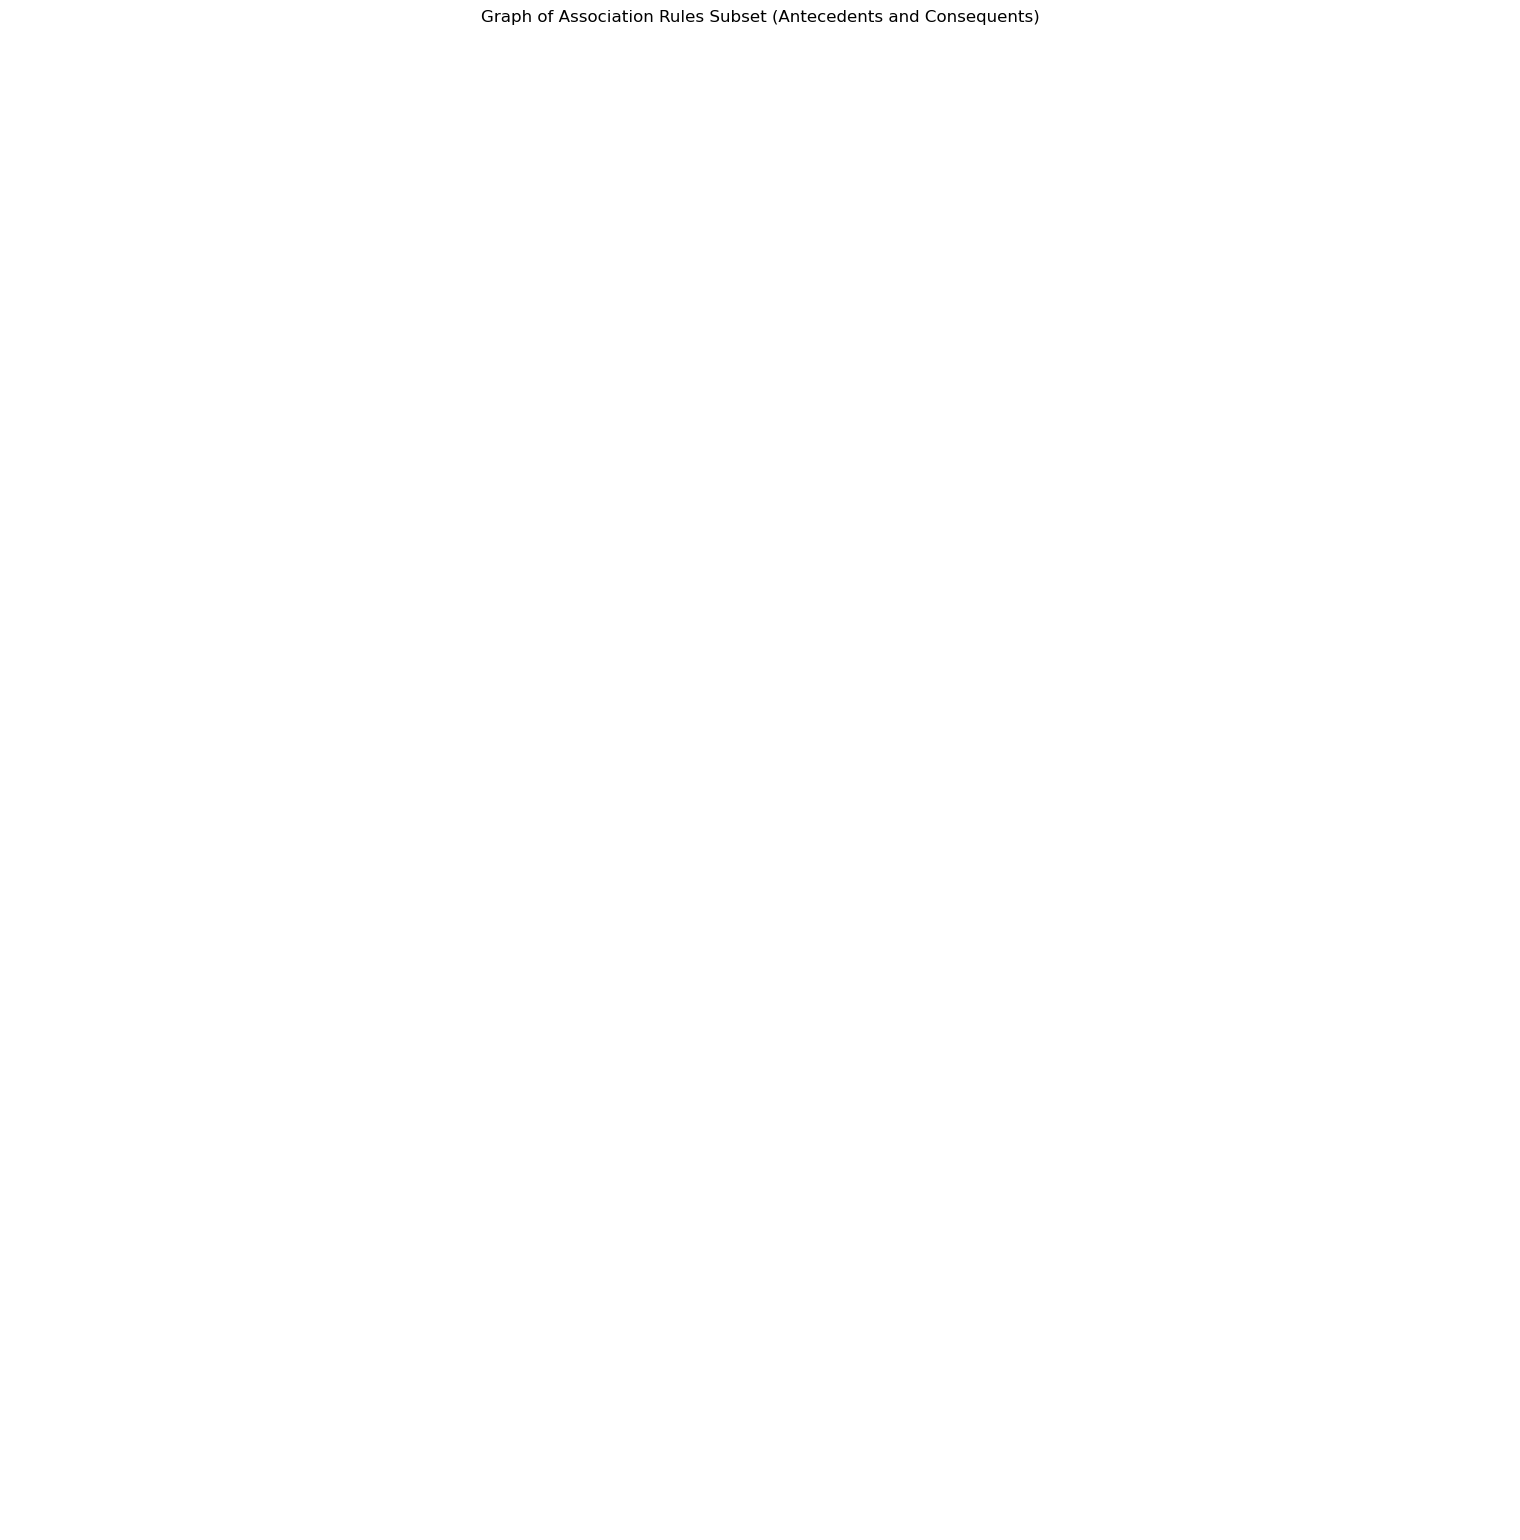

In [19]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the directed graph
graph_rules_subset = nx.MultiDiGraph()

# Add edges from the subset: connect antecedent to consequent with weight as lift
edges = [
    (row['antecedent_item'], row['consequent_item'], {'lift': row['lift']})
    for _, row in df_rules_subset.iterrows()
]

# Add the edges to the graph
graph_rules_subset.add_edges_from(edges)

# Set up the plot figure size and other parameters
plt.figure(figsize=(15, 15))  # Larger figure size

# Get positions for nodes using spring layout
pos = nx.spring_layout(graph_rules_subset, k=0.5, seed=42)  # Seed added for consistency

# Draw the nodes and edges with labels
nx.draw(
    graph_rules_subset, 
    pos, 
    with_labels=True, 
    node_size=1000,  # Increased node size for better visibility
    font_size=10,    # Adjusted font size
    node_color='lightblue', 
    font_color='black',
    edge_color='gray', 
    arrows=True, 
    arrowstyle='-|>',  # Directed graph with arrows
    arrowsize=20  # Arrow size for visibility
)

# Draw edge labels to show lift values
edge_labels = nx.get_edge_attributes(graph_rules_subset, 'lift')
nx.draw_networkx_edge_labels(
    graph_rules_subset, 
    pos, 
    edge_labels=edge_labels, 
    font_size=8
)

# Display the graph
plt.title("Graph of Association Rules Subset (Antecedents and Consequents)")
plt.show()



What can you tell about people who buy hummus?

I cant really tell anything based on the graph I have.

## Make a Prediction

Given that the basket of items contains the following items, use the full set of association rules to predict the next 20 most likely items (consequents) that the person will add to the basket in descending order of lift:

* `'Orange Bell Pepper'`
* `'Organic Red Bell Pepper'`

Hint: a single item in the basket may be a better predictor of some consequents than both items considered together. You must consider both or either, but not neither.

In [20]:
basket = {'Orange Bell Pepper', 'Organic Red Bell Pepper'}

df_rules[
    (df_rules['antecedent_items'].apply(lambda x: 'Orange Bell Pepper' in x)) |  # Just Orange Bell Pepper
    (df_rules['antecedent_items'].apply(lambda x: 'Organic Red Bell Pepper' in x))  # Just Organic Red Bell Pepper
] \
    .sort_values('lift', ascending=False) \
    .head(20)


,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
1025462,Banana,3346083,10895,1,6,[Organic Red Bell Pepper],0.010390,10895.0,1.904037e+09
988782,Banana,3346083,10624,1,6,[Orange Bell Pepper],0.010132,10624.0,1.856677e+09
884317,Limes,3346083,6784,1,5,[Organic Red Bell Pepper],0.006470,6784.0,1.422707e+09
874879,Limes,3346083,4761,1,5,[Orange Bell Pepper],0.004540,4761.0,9.984531e+08
893069,Organic Strawberries,3346083,12471,1,20,[Organic Red Bell Pepper],0.011893,12471.0,6.538389e+08
972480,Bag of Organic Bananas,3346083,13606,1,22,[Organic Red Bell Pepper],0.012976,13606.0,6.484960e+08
829779,Organic Hass Avocado,3346083,11641,1,20,[Organic Red Bell Pepper],0.011102,11641.0,6.103231e+08
929544,Organic Baby Spinach,3346083,10306,1,20,[Organic Red Bell Pepper],0.009829,10306.0,5.403307e+08
449846,Red Peppers,3346083,5529,1,11,[Orange Bell Pepper],0.005273,5529.0,5.270519e+08
866996,Large Lemon,3346083,5322,1,11,[Orange Bell Pepper],0.005075,5322.0,5.073196e+08


## Bonus: Other Interesting Findings

Find and share something else interesting about these association rules. It can be a graph, table, or some other format that illustrates your point.